# Sentiment Analysis on Movie Reviews

This dataset contains two columns: review and sentiment. The review column includes text data **(movie reviews)**, and the sentiment column labels each review as either `"positive"` or `"negative."` The main aim is to develop a model that can predict positive or negative reviews of different movie sentiments.




## Import Libraries

Import all necessary libraries to be used in the analysis process.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

# Download necessary NLTK resources

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

### Load the dataset

Load the dataset and display the first few rows of the datatset.

In [2]:
# Example of using absolute path (adjust based on your system)
movie_df = pd.read_csv('/Users/mac/Imdb/notebook/imdb_moview_reviews_(1)_(3).ipynb')

In [3]:
movie_df.head(30)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Quick overview of the data

In [4]:
print(movie_df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [5]:
movie_df.dtypes

,0
review,object
sentiment,object


# Visualize the Distribution of Reviews (Positive vs. Negative)

This step visualizes how many reviews are positive and how many are negative. The reviews are equal which means our dataset will not be biased.

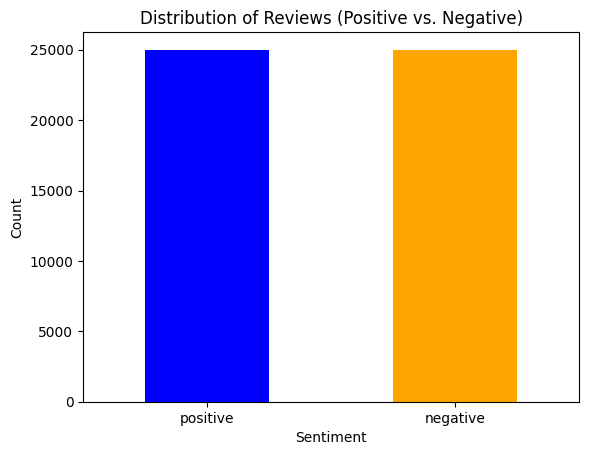

In [6]:
movie_df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Reviews (Positive vs. Negative)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Step 1: Text Preprocessing

### Convert all text to lowercase

This ensures that all text is uniform (e.g., "Great" and "great" are treated the same) and consistency across the dataset.

In [7]:
movie_df['review'] = movie_df['review'].str.lower()

In [8]:
movie_df.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove HTML Tags
This ensures that the dataset does not have any HTML Markup that might interfere with analysis

In [9]:
from bs4 import BeautifulSoup

# Function to safely remove HTML tags
def remove_html(text):
    if isinstance(text, str) and ("<" in text and ">" in text):  # Check if text looks like HTML
        return BeautifulSoup(text, "html.parser").get_text()
    return text  # Return as is if it's not HTML-like

# Apply the function to the 'review' column
movie_df['review'] = movie_df['review'].apply(remove_html)

# Display the first 5 rows of the cleaned DataFrame
movie_df.head(5)


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove URLs
URLs are not useful for sentiment analysis thus removing them ensures the dataset is cleaner

In [10]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

movie_df['review'] = movie_df['review'].apply(remove_urls)
movie_df.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove both numerical and written numbers
This ensures that the numbers do not interfere with the text-based analysis.

In [11]:
def remove_numbers(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove numerical digits
    text = re.sub(r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', '', text)  # Remove written numbers
    return text

movie_df['review'] = movie_df['review'].apply(remove_numbers)
movie_df.head(5)

,review,sentiment
0,of the other reviewers has mentioned that aft...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove measurements
Irrelevant units of measurements that do not contribute to sentiment classification are removed.

In [12]:
def remove_measurements(text):
    # Regular expression to match measurements (e.g., numbers followed by units)
    # Example units: kg, meters, cm, lb, g, etc.
    pattern = r'\b\d+\.?\d*\s?(kg|cm|meter|meters|mm|g|lb|oz|km|miles|inch|inches|feet|ft)\b'

    # Remove all measurements from the text
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return cleaned_text

movie_df['review'] = movie_df['review'].apply(remove_measurements)
movie_df.head(5)

,review,sentiment
0,of the other reviewers has mentioned that aft...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove named entities (NER)
Named entities(e.g., names of people, places) which may not contribute to meaningful classification are removed.

In [14]:
import spacy

# Load the pre-trained spaCy model for named entity recognition
nlp = spacy.load('en_core_web_sm')

# Function to remove named entities
def remove_named_entities(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.ent_type_])

# Apply the function to the 'cleaned_review' column
movie_df['review'] = movie_df['review'].apply(remove_named_entities)
movie_df.head(5)

,review,sentiment
0,of the other reviewers has mentioned that af...,positive
1,a wonderful little production . the filming te...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there 's a family where a little boy...,negative
4,"petter mattei 's "" love in the time of money ""...",positive


### Tokenization and Removal of Stop Words

In [16]:
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

movie_df['tokens'] = movie_df['review'].apply(tokenize_and_remove_stopwords)
movie_df.head(5)

,review,sentiment,tokens
0,of the other reviewers has mentioned that af...,positive,"[reviewers, mentioned, watching, oz, episode, ..."
1,a wonderful little production . the filming te...,positive,"[wonderful, little, production, ., filming, te..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, ,,..."
3,basically there 's a family where a little boy...,negative,"[basically, 's, family, little, boy, (, jake, ..."
4,"petter mattei 's "" love in the time of money ""...",positive,"[petter, mattei, 's, ``, love, time, money, ``..."


### Remove special characters and punctuation

Characters such as `,`are not useful for classification.

In [17]:
def remove_special_chars(text):
    return re.sub(r'[^\w\s]', '', text)

movie_df['review'] = movie_df['review'].apply(remove_special_chars)
movie_df.head(5)

,review,sentiment,tokens
0,of the other reviewers has mentioned that af...,positive,"[reviewers, mentioned, watching, oz, episode, ..."
1,a wonderful little production the filming tec...,positive,"[wonderful, little, production, ., filming, te..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, ,,..."
3,basically there s a family where a little boy ...,negative,"[basically, 's, family, little, boy, (, jake, ..."
4,petter mattei s love in the time of money is...,positive,"[petter, mattei, 's, ``, love, time, money, ``..."


### Stemming

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

movie_df['tokens'] = movie_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Display the cleaned tokens
movie_df[['review', 'tokens']].head()

In [ ]:
movie_df.head(5)

In [ ]:
# def clean_text(text):
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

#     # Remove numbers and measurements
#     text = re.sub(r'\d+', '', text)

#     # Remove special characters and punctuation
#     text = re.sub(r'[^\w\s]', '', text)

#     return text

# movie_df['review'] = movie_df['review'].apply(clean_text)
# print(movie_df['review'].head())
# movie_df.head(5)

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


<!-- #### Remove numbers -->

In [ ]:
# # Function to remove numbers from the text
# def remove_numbers(text):
#     return re.sub(r'\d+', '', text)

# # Apply the function to remove numbers from the reviews
# movie_df['review'] = movie_df['review'].apply(remove_numbers)

# # Display the cleaned reviews without numbers
# movie_df.head(5)


#### Remove smiley faces/emoticons

This ensures that reviews do not contain emojis or smileys that could interfere with accurate text processing and analysis.

In [ ]:
pip install emoji

In [ ]:
import emoji

# Function to remove emojis and smileys
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Apply the function to the 'cleaned_review' column
movie_df['review'] = movie_df['review'].apply(remove_emojis)

# Display the cleaned reviews without smiley faces
movie_df.head(5)



,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


### Tokenization and Removal of Stop Words
This aims to split each review into individual words or tokens, which serve as the foundation for further text analysis.Removing the stopwords such as "the" are removed wwhich are not helpful for classification.

In [ ]:
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

movie_df['tokens'] = movie_df['review'].apply(tokenize_and_remove_stopwords)

# Display the first few cleaned tokens
movie_df[['review', 'tokens']].head()
movie_df.head(5)

,review,sentiment,tokens
0,one of the other reviewers has mentioned that ...,positive,"[one, reviewers, mentioned, watching, oz, epis..."
1,a wonderful little production the filming tech...,positive,"[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,basically theres a family where a little boy j...,negative,"[basically, theres, family, little, boy, jake,..."
4,petter matteis love in the time of money is a ...,positive,"[petter, matteis, love, time, money, visually,..."


## Stemming and handling negations
This ensures that words are reduced to their basic form making it easier to group similar words with the same meaning

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Apply stemming to the tokens
movie_df['tokens'] = movie_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Handle negations like "not good" -> "not_good"
movie_df['review'] = movie_df['review'].apply(lambda x: re.sub(r'not\s(\w+)', r'not_\1', x))

# Check the cleaned and processed dataset
movie_df.head()

In [ ]:
movie_df.head(5)

,review,sentiment,tokens
0,one of the other reviewers has mentioned that ...,positive,"[one, review, mention, watch, oz, episod, youl..."
1,a wonderful little production. the filming tec...,positive,"[wonder, littl, product, film, techniqu, unass..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonder, way, spend, time, hot, summe..."
3,basically there's a family where a little boy ...,negative,"[basic, there, famili, littl, boy, jake, think..."
4,"petter mattei's ""love in the time of money"" is...",positive,"[petter, mattei, love, time, money, visual, st..."


### Remove punctuation, numbers, and symbols

In [ ]:
movie_df['review'] = movie_df['review'].apply(lambda x: re.sub('[^a-zA-Z\\s]', '', x))

In [ ]:
movie_df.head(5)

,review,sentiment,tokens
0,one of the other reviewers has mentioned that ...,positive,"[one, review, mention, watch, oz, episod, youl..."
1,a wonderful little production the filming tech...,positive,"[wonder, littl, product, film, techniqu, unass..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonder, way, spend, time, hot, summe..."
3,basically theres a family where a little boy j...,negative,"[basic, there, famili, littl, boy, jake, think..."
4,petter matteis love in the time of money is a ...,positive,"[petter, mattei, love, time, money, visual, st..."


## Convert Text into Numerical Format(TF-IDF vectorizer)

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the reviews into a sparse matrix
tfidf_matrix = vectorizer.fit_transform(movie_df['review'])

# Get feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Example: Get the TF-IDF scores for the first review
first_review_scores = tfidf_matrix[0]

# Convert the sparse matrix for the first review to a dictionary
# Using first_review_scores.toarray() would cause MemoryError, so we avoid that
importance_scores = {feature_names[i]: first_review_scores[0, i] for i in first_review_scores.nonzero()[1]}

# Print the TF-IDF scores for the first review
print(importance_scores)

{'darker': 0.07392824124005352, 'touch': 0.05779572508721443, 'viewingthats': 0.12613296847297034, 'uncomfortable': 0.07117417603194795, 'comfortable': 0.07300344133112453, 'experience': 0.048467165491285116, 'skills': 0.06481127221502742, 'street': 0.055403553796047236, 'lack': 0.048551449243730234, 'bitches': 0.10122498351330333, 'turned': 0.049842925817350336, 'class': 0.053466504973633366, 'middle': 0.051573478214165316, 'mannered': 0.08815807893149269, 'away': 0.03830533923459747, 'order': 0.04976867890869979, 'kill': 0.04800872211143774, 'inmates': 0.1694973920234481, 'nickel': 0.10908257791958548, 'sold': 0.0699133097213164, 'wholl': 0.18803068663135117, 'guards': 0.07889918281586587, 'crooked': 0.08310687609551669, 'injustice': 0.08403549781011765, 'notjust': 0.0568275795954894, 'graphic': 0.06562603641779212, 'levels': 0.06551755604467, 'high': 0.04230467964111475, 'accustomed': 0.08815807893149269, 'got': 0.03570160256042939, 'taste': 0.058341306482327354, 'developed': 0.0606

### Bag of Words(BoW)

The Bag of Words model is a way of representing text data where each unique word in the corpus is represented as a feature. The model doesn't consider grammar or word order, just the frequency of words in the text.

**Aim**: To convert the movie reviews into a numerical format by counting the frequency of words using the Bag of Words model.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the 'review' column and transform the text into a bag of words
bow_matrix = vectorizer.fit_transform(movie_df['cleaned_review'])

# Get the feature names (i.e., unique words)
feature_names = vectorizer.get_feature_names_out()

# Convert the Bag of Words model to a DataFrame for easier understanding
movie_df = pd.DataFrame(bow_matrix.toarray(), columns=feature_names)

# Display the first 5 rows of the Bag of Words matrix
movie_df.head(5)


### Word cloud
A Word Cloud visually represents the most frequent words in the text, where the size of each word indicates its frequency or importance.

**Aim**: To visualize the most frequent words in the movie reviews using a word cloud.

* CountVectorizer(): This function converts
the text into a bag of words model by counting the occurrences of each word.

* fit_transform(): This method is applied to fit the vectorizer on the text and transform it into a sparse matrix where each row corresponds to a document, and each column corresponds to a word.

* get_feature_names_out(): This retrieves the vocabulary (list of words) created by the vectorizer.

In [ ]:
pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the reviews into one large text for the word cloud
all_reviews = ' '.join(movie_df['review'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


**Bag of Words**: Transforms the movie reviews into a numerical representation by counting word occurrences. This method helps in feeding the text data into machine learning models.

**Word Cloud**: Creates a visual representation of the most frequent words in the dataset, providing quick insights into common themes in the movie reviews.

### Convert sentiment to numerical values (binary: 1 for positive, 0 for negative)

In [ ]:
# y = pd.get_dummies(movie_df['sentiment'], drop_first=True).values.ravel()  # Positive = 1, Negative = 0

## Training

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

### Naive Bayes

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train.ravel())
y_pred_nb = nb_model.predict(X_test)
print(f'Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}')

Naive Bayes Accuracy: 0.8676


### Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log)}')

Logistic Regression Accuracy: 0.8937


### Random Forest

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train.ravel())
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.8577


### Decision Tree

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train.ravel())
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {tree_accuracy:.4f}')

Decision Tree Accuracy: 0.7275


### Confusion matrix for Naive Bayes

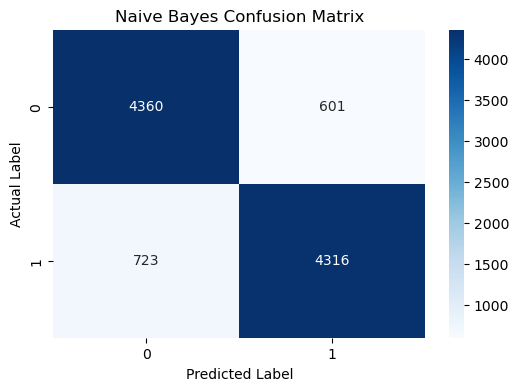

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Logistic Regression

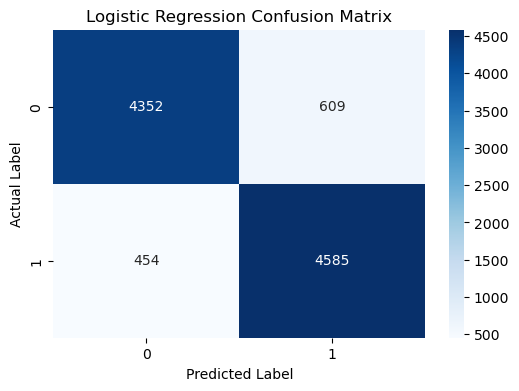

In [ ]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Random Forest

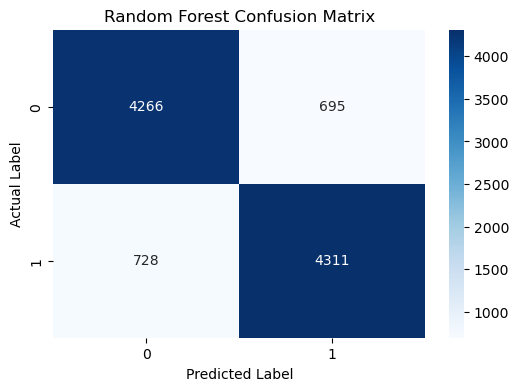

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Decision Tree

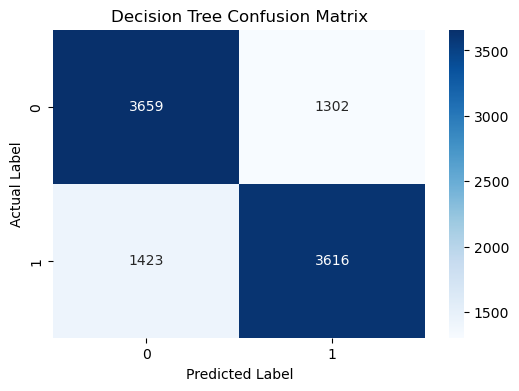

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues")
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Sentiment Classification Model Results

#### 1. **Model Performance**
- **Logistic Regression Accuracy:** 89.42%
- **Naive Bayes Accuracy:** 86.76%
- **Random Forest Accuracy:** 85.58%
- **Decision Tree Accuracy:** 72.33%

Logistic Regression performed best, with an accuracy of **89.42%**, followed by Naive Bayes and Random Forest.

| Model                | Accuracy  |
|----------------------|-----------|
| Logistic Regression   | 89.42%    |
| Naive Bayes           | 86.76%    |
| Random Forest         | 85.58%    |
| Decision Tree         | 72.33%    |


#### 2. **Key Insights**
- **Text Preprocessing:** Cleaning text (removal of numbers, punctuation, and stop words) improved data quality.
- **TF-IDF Representation:** Helped focus on important words, reducing the influence of common terms.
- **Class Imbalance:** Potential issue, slightly affecting Naive Bayes accuracy.

#### 3. **Challenges**
- **Models Overfitting:** Some models, particularly Decision Trees and Random Forest, were prone to overfitting, leading to poorer generalization on unseen data.


#### 4. **Conclusion**
**Logistic Regression** achieved the highest accuracy and is the most reliable model for this task. Future steps include hyperparameter tuning and feature engineering (e.g., bigrams or word embeddings) to further enhance performance.
